In [ ]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
#from scipy.io import netcdf
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

# 1.  keep the bgr that have t.s, temp, and prec to build models

In [ ]:
# import freq df
freq_level =  pd.read_csv("dataset/modeling/freq_level.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print("details: ")
print(f"daily_freq: {freq_level[freq_level['daily']].shape}")
print(f"mid_weekly_freq: {freq_level[freq_level['mid_weekly']].shape}")
print(f"weekly_freq: {freq_level[freq_level['weekly']].shape}")
print(f"fortnight_freq: {freq_level[freq_level['fortnight']].shape}")
print(f"low_freq_freq: {freq_level[freq_level['low_freq']].shape}")

freq_level.head()

In [ ]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/modeling/grouped_t_s.csv")
grouped_t_s = grouped_t_s.set_index("proj_id")
print(grouped_t_s.shape)
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
grouped_t_s.head()

### the ts df has the same length as freq
#### 

In [ ]:
# compute the length of each t s and save the res in freq_level and in the grouped_t_s
freq_level["length"] = grouped_t_s.apply(lambda row:len(row[:].dropna()), axis =1)
freq_level.head()

In [ ]:
# add a column for freq in the daily_temp
def add_freq(row):
    #1. get the t s name
    #2. determine freq
    #3. compute ave
    #bgr = ave_temp.index[7569]
    freq = 0
    if row["daily"]:
        #print("daily")
        freq = 1
    if row["mid_weekly"]:
        #print("mid_weekly")
        freq = 4
    if row["weekly"]:
        #print("weekly")
        freq = 7
    if row["fortnight"]:
        #print("fortnight")
        freq = 14
    if row["low_freq"]:
        #print("low_freq")
        freq = 30
    return freq

freq_level["freq"] = freq_level.apply(lambda row:add_freq(row), axis=1)
freq_level.head()

In [ ]:
# import daily_temp (ave computed in place)
ave_temp = pd.read_csv("dataset/modeling/ave_temp.csv").set_index("proj_id")
ave_temp.columns= convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
ave_temp.head()


### there are 12382 rows in ave_temp, and 12590 in freq -> keep the intersection

In [ ]:
# keep the inntersection between freq_level and the ave_temp
temp_freq_df = pd.concat([freq_level, ave_temp[ave_temp.columns[:-1]]], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(temp_freq_df.shape)
temp_freq_df.head()

In [ ]:
# split the freq df again
freq_level = temp_freq_df.drop(temp_freq_df.columns[7:], axis =1)
print("freq_level: ",freq_level.shape)
freq_level.head()

In [ ]:
# import the cum_prec 
cum_prec=pd.read_csv("dataset/modeling/cum_prec.csv").set_index("proj_id")
cum_prec.columns=convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
cum_prec.head()

### again 12326 rows in cum_prec and 12382 rows in the last freq df -> keep the intersection

In [ ]:
#  keep the inntersection between freq_level and the cum_prec
prec_freq_df = pd.concat([freq_level, cum_prec[cum_prec.columns[:-1]]], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(prec_freq_df.shape)
prec_freq_df.head()

In [ ]:
# split the freq df again
freq_level = prec_freq_df.drop(prec_freq_df.columns[7:], axis =1)
print("freq_level: ",freq_level.shape)
freq_level.head()

### these 12326 t s will be used in modeling, which all have groundwater ts, and coresponding temp, and prec  

In [ ]:
# save the last freq df, 
# then this filter will be apply again on the 3 t s to be sure that all of them have the same dims
# and save the resulted dfs of ts, temp, prec
freq_level.to_csv("dataset/modeling/freq_level.csv")

In [ ]:
# apply the filter (last freq_level) on the grouped_t_s
grouped_t_s_freq_df = pd.concat([freq_level, grouped_t_s[grouped_t_s.columns[:-31]]], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(f"grouped_t_s_freq_df: {grouped_t_s_freq_df.shape}")
grouped_t_s = grouped_t_s_freq_df.drop(grouped_t_s_freq_df.columns[:5], axis =1)
grouped_t_s.head()
#grouped_t_s.to_csv("dataset/modeling/grouped_t_s.csv")

In [ ]:
# apply the filter (last freq_level) on ave temp
temp_freq_df = pd.concat([freq_level, ave_temp[ave_temp.columns[:-1]]], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(f"temp_freq_df:{temp_freq_df.shape}")
ave_temp = temp_freq_df.drop(temp_freq_df.columns[:5], axis =1)
ave_temp.head()
# ave_temp.to_csv("dataset/modeling/ave_temp.csv")

In [ ]:
# apply the filter (last freq_level) on cum_prec
prec_freq_df = pd.concat([freq_level, cum_prec[cum_prec.columns[:-1]]], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
print(f"temp_freq_df:{prec_freq_df.shape}")
cum_prec = prec_freq_df.drop(prec_freq_df.columns[:5], axis =1)
cum_prec.head()
#cum_prec.to_csv("dataset/modeling/cum_prec.csv")

### 12326 t s with corresponding ave_temp, cum_prec to use in modeling

## 
# 2. sampling and basic analysis

In [19]:
# compute the regular length of a  t s ()
d = int((pd.to_datetime("2012-11-30") - pd.to_datetime("1995-01-01")).days)
d4 = int((pd.to_datetime("2012-11-30") - pd.to_datetime("1995-01-01")).days/4)
w = int((pd.to_datetime("2012-11-30") - pd.to_datetime("1995-01-01")).days/7)
w2 = int((pd.to_datetime("2012-11-30") - pd.to_datetime("1995-01-01")).days/14)
m =  int ((pd.to_datetime("2012-11-30") - pd.to_datetime("1995-01-01")).days/30)
print(f"from 1995-01-01 to 2012-11-30: {d} days")
print(f"from 1995-01-01 to 2012-11-30: {d4} 4-days")
print(f"from 1995-01-01 to 2012-11-30: {w} weeks")
print(f"from 1995-01-01 to 2012-11-30: {w2} fortnights")
print(f"from 1995-01-01 to 2012-11-30: {m} months")

from 1995-01-01 to 2012-11-30: 6543 days
from 1995-01-01 to 2012-11-30: 1635 4-days
from 1995-01-01 to 2012-11-30: 934 weeks
from 1995-01-01 to 2012-11-30: 467 fortnights
from 1995-01-01 to 2012-11-30: 218 months


In [20]:
# import freq df
freq_level =  pd.read_csv("dataset/modeling/freq_level.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print("details: ")
print(f"daily_freq: {freq_level[freq_level['daily']].shape}")
print(f"mid_weekly_freq: {freq_level[freq_level['mid_weekly']].shape}")
print(f"weekly_freq: {freq_level[freq_level['weekly']].shape}")
print(f"fortnight_freq: {freq_level[freq_level['fortnight']].shape}")
print(f"low_freq_freq: {freq_level[freq_level['low_freq']].shape}")

freq_level.head()

(12326, 7)
 
details: 
daily_freq: (3028, 7)
mid_weekly_freq: (957, 7)
weekly_freq: (5713, 7)
fortnight_freq: (1658, 7)
low_freq_freq: (970, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,length,freq
proj_id,,,,,,,
BB_25470023,False,False,True,False,False,567,7
BB_25470024,False,False,True,False,False,566,7
BB_25480025,False,False,True,False,False,567,7
BB_25480026,False,False,True,False,False,569,7
BB_25481088,True,False,False,False,False,5019,1


In [ ]:

fig, axs = plt.subplots(3,2, figsize=(25,20))
fig.suptitle('Vertically stacked subplots')

axs[0,0].hist(freq_level[freq_level["freq"]==1]["length"], bins=5)
axs[0,0].set_title('length dist of freq 1 t s, regular= 6574 days')

axs[0,1].hist(freq_level[freq_level["freq"]==4]["length"], bins=5)
axs[0,1].set_title('length dist of freq 4 t s, regular= 1643.5 4-days')

axs[1,0].hist(freq_level[freq_level["freq"]==7]["length"], bins=10)
axs[1,0].set_title('dlength dist of freq 7 t s, regular= 939.14 weeks')

axs[1,1].hist(freq_level[freq_level["freq"]==14]["length"], bins=10)
axs[1,1].set_title('length dist of freq 14 t s, regular= 469.57 fortnights')

axs[2,0].hist(freq_level[freq_level["freq"]==30]["length"], bins=10)
axs[2,0].set_title('length dist of freq 30 t s, regular= 219.13 months')


### from the previous analysis, the weekly, fortnight, and monthly t s are not affected very much by the freq division used before (the majority are regular), there is a bit problem in the daily and mid-weekly.

### we will pick randomly 5  t s (one from each level of the max in the hist) from each level of freq (daily, mid_weekly,  weekly,  fortnight, monthly)    -> we build 25 basic models which we can easily generalize to any other t s with the same setting (freq and length)

In [21]:
# compute the ranges (bins) of lengths at each freq level
# i.e hist of the length at each freq level
f1 =freq_level[freq_level["freq"]==1]
f1len =freq_level[freq_level["freq"]==1]["length"]
counts1, bins1 = np.histogram(f1len, bins=5)

f4 =freq_level[freq_level["freq"]==4]
f4len =freq_level[freq_level["freq"]==4]["length"]
counts4, bins4 = np.histogram(f4len, bins=5)

f7 =freq_level[freq_level["freq"]==7]
f7len =freq_level[freq_level["freq"]==7]["length"]
counts7, bins7 = np.histogram(f7len)

f14 =freq_level[freq_level["freq"]==14]
f14len =freq_level[freq_level["freq"]==14]["length"]
counts14, bins14 = np.histogram(f14len)

f30 =freq_level[freq_level["freq"]==30]
f30len =freq_level[freq_level["freq"]==30]["length"]
counts30, bins30 = np.histogram(f30len)


In [22]:
# add a flag columns to each freq df
def length_class(df, bins, counts):
    
    d =pd.DataFrame([bins, bins[1:], counts]).T.sort_values(by=2, ascending=False, ignore_index=True)
    d.columns=["len1","len2","num_of_t_s"]

    x =df["length"]
    if d["len1"][0] <= x < d["len2"][0]:
        return 1
    if d["len1"][1] <= x < d["len2"][1]:
        return 2
    if d["len1"][2] <= x < d["len2"][2]:
        return 3
    if d["len1"][3] <= x <=d["len2"][3]:
        return 4
    if d["len1"][4] <= x <=d["len2"][4]:
        return 5

    
f1["len_class"]=f1.apply(length_class, args=(bins1,counts1),axis=1)
f4["len_class"]=f4.apply(length_class, args=(bins4,counts4),axis=1)
f7["len_class"]=f7.apply(length_class, args=(bins7,counts7),axis=1)
f14["len_class"]=f14.apply(length_class, args=(bins14,counts14),axis=1)
f30["len_class"]=f30.apply(length_class, args=(bins30,counts30),axis=1)

In [26]:
import random
# pick the sample t s
sample_t_s =[]
for len_level in sorted(f1["len_class"].unique())[:5]:
    sample_t_s.append(random.choice(f1[f1["len_class"]==len_level].index))
    sample_t_s.append(random.choice(f4[f4["len_class"]==len_level].index))
    sample_t_s.append(random.choice(f7[f7["len_class"]==len_level].index))
    sample_t_s.append(random.choice(f14[f14["len_class"]==len_level].index))
    sample_t_s.append(random.choice(f30[f30["len_class"]==len_level].index))
    
# the picked sample in freq df
freq_sample = freq_level.loc[sample_t_s].sort_values(by=["freq","length"])
print(freq_sample.shape)
freq_sample

(25, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,length,freq
proj_id,,,,,,,
BE_15063,True,False,False,False,False,1156,1
NI_40003038,True,False,False,False,False,1775,1
NI_9853151,True,False,False,False,False,3943,1
BY_21142,True,False,False,False,False,5023,1
BY_8242,True,False,False,False,False,6518,1
SN_54370001,False,True,False,False,False,453,4
NW_80303614,False,True,False,False,False,1148,4
ST_35330001,False,True,False,False,False,1600,4
NI_40000507,False,True,False,False,False,2087,4


<BarContainer object of 25 artists>

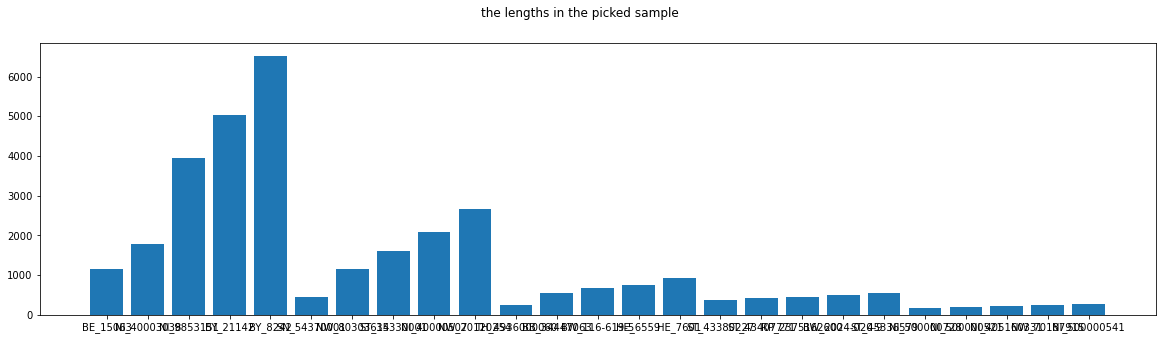

In [27]:
# look at the lengths in the picked sample
fig, axs = plt.subplots(1,1, figsize=(20,5))
fig.suptitle('the lengths in the picked sample')

axs.bar(freq_sample.index,freq_sample["length"])
#axs.set_title('length dist of freq 1 t s, regular= 6574 days')

#axs[1].bar(freq_sample1.index,freq_sample1["length"])
#axs[1].set_title('length dist of freq 4 t s, regular= 1643.5 4-days')


In [28]:
# save the sample
k = 5
freq_sample.to_csv(f"dataset/modeling/sample{k}/freq_sample.csv")

# 
## Sampling ts, temp, and prec

In [32]:
# import the sample
k = 5
freq_level = pd.read_csv(f"dataset/modeling/sample{k}/freq_sample.csv").set_index("proj_id")
print(freq_level.shape)
freq_level.head()

(25, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,length,freq
proj_id,,,,,,,
BE_15063,True,False,False,False,False,1156,1
NI_40003038,True,False,False,False,False,1775,1
NI_9853151,True,False,False,False,False,3943,1
BY_21142,True,False,False,False,False,5023,1
BY_8242,True,False,False,False,False,6518,1


In [5]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/modeling/grouped_t_s.csv")
grouped_t_s = grouped_t_s.set_index("proj_id")
print(grouped_t_s.shape)
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
#grouped_t_s.head()

# import daily_temp (ave computed in place)
ave_temp = pd.read_csv("dataset/modeling/ave_temp.csv").set_index("proj_id")
ave_temp.columns= convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
#ave_temp.head()

# import the cum_prec 
cum_prec=pd.read_csv("dataset/modeling/cum_prec.csv").set_index("proj_id")
cum_prec.columns=convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
#cum_prec.head()

(12326, 6546)
(12326, 6546)
(12326, 6546)


In [33]:
sample_t_s = freq_level.index
# capture the sample from the original df
sample_t_s_df =grouped_t_s.loc[sample_t_s].sort_values(by=["freq","length"])
sample_temp_df =ave_temp.loc[sample_t_s].sort_values(by=["freq", "length"])
sample_prec_df =cum_prec.loc[sample_t_s].sort_values(by=["freq", "length"])


In [34]:
# save the sample
sample_t_s_df.to_csv(f"dataset/modeling/sample{k}/sample_t_s.csv")
sample_temp_df.to_csv(f"dataset/modeling/sample{k}/sample_temp.csv")
sample_prec_df.to_csv(f"dataset/modeling/sample{k}/sample_prec.csv")

## end of sampling

## general ploting 

In [ ]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = sample_temp_df[idx].loc[bgr]
    prec = sample_prec_df[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


In [ ]:
# plot the sample
ts1 = sample_t_s_df.iloc[24]
#print(f"ts length:{ts1[0]}, freq: {ts1[1]}")
df = create_one_ts_df(ts1)
#print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
#a,b = 2500,2700
axs[0].plot(df["ts"])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"])
axs[1].set_title('temp')
axs[2].plot(df["prec"])
axs[2].set_title('prec')